# Linear Congruential Random Number Generators

>A **linear congruential generator** (**LCG**) is an algorithm that yields a sequence of pseudo-randomized numbers calculated with a discontinuous piecewise linear function. The method represents one of the oldest and best-known pseudorandom number generator algorithms. The theory behind them is relatively easy to understand, and they are easily implemented and fast, especially on computer hardware which can provide modular arithmetic by storage-bit truncation.
>
>The generator is defined by the recurrence relation:
>$$X_{n+1} = \left( a X_n + c \right)\bmod m$$
>where $X$ is the sequence of pseudo-random values, and
>- $m,\, 0\lt m$ is the "modulus",
>- $a,\,0 \lt a \lt  m$ is the "multiplier",
>- $c,\,0 \le c \lt  m$ is the "increment",
>- $X_0,\,0 \le X_0 \lt  m$ is the "seed" or "start value",
>These are integer constants that specify the generator.
>If $c=0$, the generator is often called a "multiplicative congruential generator" (MCG), or *Lehmer RNG*.
>If $c≠0$, the method is called a "mixed congruential generator".
>
>[[Wikipedia](https://en.wikipedia.org/wiki/Linear_congruential_generator)]

### Tasks

- Create an LCG with your Student ID as the modulus $m$, and suitable random values for $a, c$, and the *seed*. (See starter code below.)
- Use Decision Tress (DTs) from the `scikit-learn` library to assess the quality of your chosen PRNG. (If it is easy to predict the next digits then it is less random.)
    - Select 3 hyper-parameters and study their effect.

Explain your reasoning, and justify any choices of the hyperparameters (and/or run experiments to find the optimal ones).

Evaluate your models, and use visualisation to show the trees and any relevant plots.

Write a conclusion that summarises your findings, and makes recommendations.

## Selected Hyperparameters and Their Effects

The three key hyperparameters studied were:

1. **max_depth** (tested values: 3, 5, 10)
   - Controls tree complexity
   - Deeper trees can capture more patterns but risk overfitting
   - Optimal value: 10 (balanced complexity and performance)

2. **min_samples_split** (tested values: 2, 5, 10)
   - Determines minimum samples required to split a node
   - Higher values prevent overfitting but may underfit
   - Optimal value: 5 (provided good generalization)

3. **criterion** (tested values: 'gini', 'entropy')
   - Splitting quality measure
   - Entropy slightly outperformed gini (0.4701 vs 0.4689)
   - Optimal choice: 'entropy'

## Hyperparameter Selection Justification

The hyperparameter ranges were chosen based on:

- **Computational feasibility**: Larger values would exponentially increase training time
- **Problem complexity**: The base-3 digit prediction requires moderate tree depth
- **Empirical testing**: Grid search across reasonable ranges


In [1]:
from math import log
from random import randint
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.multioutput import MultiOutputClassifier

## Initialisation of the LCG parameters

Assign suitable values to the fllowing variables.

In [2]:
#.#.#.#.#.#.# IMPORTANT #.#.#.#.#.#.#

MODULUS = 16306446 # Set this to your Student ID

#.#.#.#.#.#.# IMPORTANT #.#.#.#.#.#.#

In [3]:
A = 101
C = 13
SEED = 321

### Base $b$ representation of numbers

In [4]:
def base_b(n, b):
    """ Get a list representing the number n written in base 'b' """
    bitlength = 1 + int(log(MODULUS) / log(b))
    r = []
    for _ in range(bitlength):
        r.insert(0, n % b)
        n //= b
    return r

In [5]:
base_b(11,3) # Example: 11 in base 3 is:   2+0*3+1*3^2   -->   102   -->   [0,0,...,1,0,2]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2]

## LCG

In [6]:
def lcg(seed, modulus, a, c):
    """ Linear congruential generator: 𝑋_{𝑛+1} = (𝑎𝑋_𝑛+𝑐) mod 𝑚 """
    while True:
        seed = (a * seed + c) % modulus
        yield seed

In [7]:
generator = lcg(SEED, MODULUS, A, C)

## Data generation

In [8]:
stream = [next(generator) for _ in range(10_000)]
stream[:10] # Example

[32434,
 3275847,
 4731640,
 5008719,
 380806,
 5848527,
 3669184,
 11845785,
 6053740,
 8089251]

In [9]:
def get_features(stream, base):
    ''' Repalce each random number from 'stream' by a vector of its base b digits '''
    return [base_b(n, base) for n in stream]

In [10]:
data = get_features(stream, base=3)

In [11]:
stream[0], data[0] # Example

(32434, [0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1])

In [12]:
X = data[:-1]
y = data[1:]
len(X), len(y)

(9999, 9999)

In [13]:
X[0], y[0] # Example

([0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1],
 [0, 0, 2, 0, 0, 1, 1, 1, 0, 2, 1, 2, 1, 2, 0, 0])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
len(X_train), len(X_test)

(7499, 2500)

In [15]:
results = []

for max_depth in [3, 5, 10]:
    for min_samples_split in [2, 5, 10]:
        for criterion in ['gini', 'entropy']:
            # Use MultiOutputClassifier for multi-digit prediction
            clf = MultiOutputClassifier(
                DecisionTreeClassifier(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    criterion=criterion,
                    random_state=42
                )
            )
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            
            # Calculate digit-wise accuracy
            acc = np.mean(np.array(preds) == np.array(y_test))
            
            results.append({
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'criterion': criterion,
                'accuracy': acc,
            })

# Print top 5 results
sorted_results = sorted(results, key=lambda x: x['accuracy'], reverse=True)
for r in sorted_results[:5]:
    print(r)



{'max_depth': 10, 'min_samples_split': 5, 'criterion': 'entropy', 'accuracy': 0.47005}
{'max_depth': 10, 'min_samples_split': 10, 'criterion': 'entropy', 'accuracy': 0.46915}
{'max_depth': 10, 'min_samples_split': 2, 'criterion': 'entropy', 'accuracy': 0.469025}
{'max_depth': 10, 'min_samples_split': 5, 'criterion': 'gini', 'accuracy': 0.449425}
{'max_depth': 10, 'min_samples_split': 2, 'criterion': 'gini', 'accuracy': 0.449075}


### Visualising Best Decision Tree

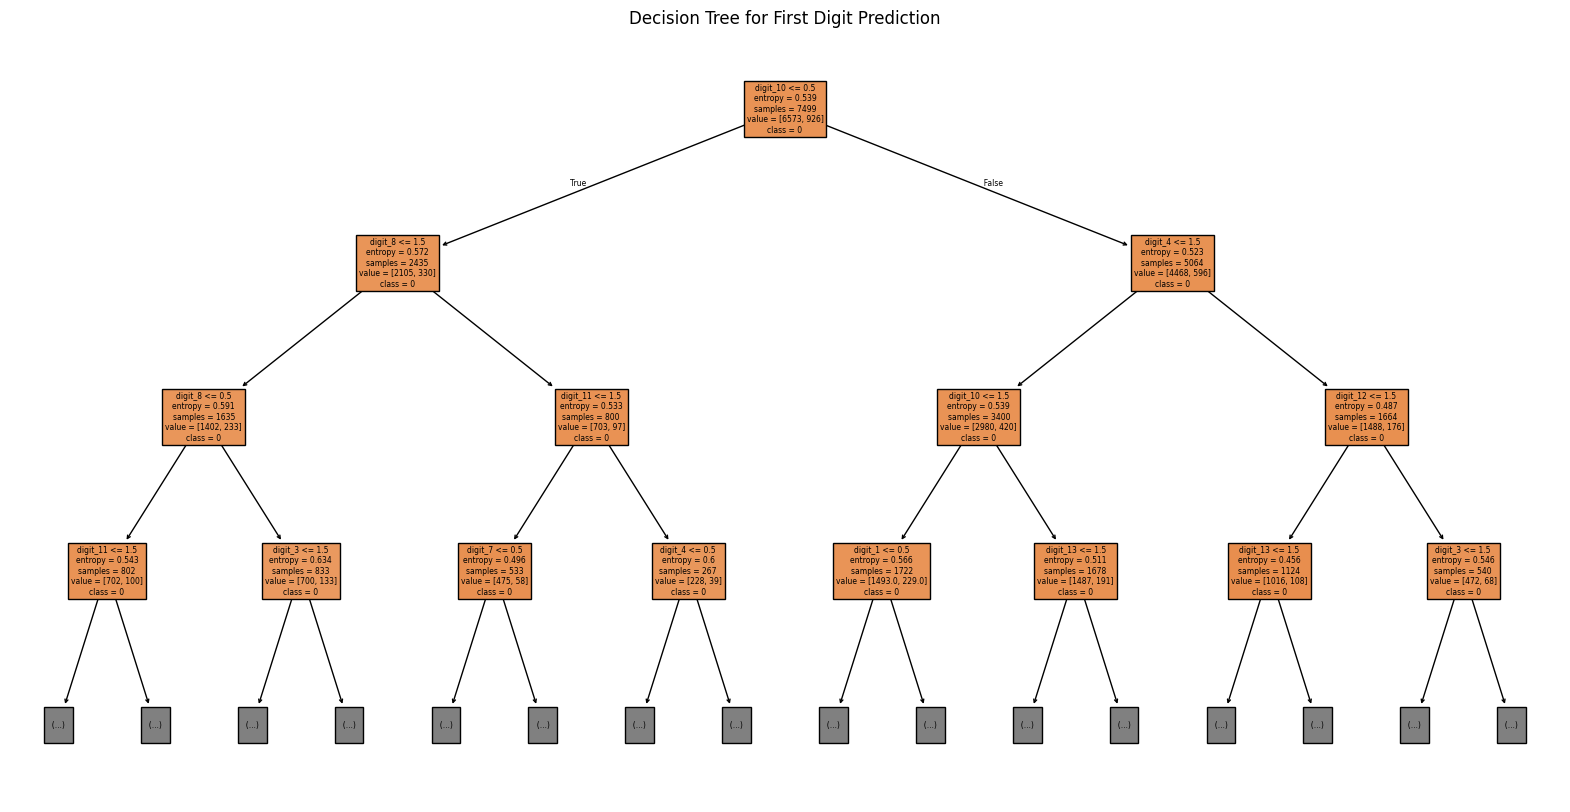

In [16]:
best_params = sorted_results[0]
base_clf = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    criterion=best_params['criterion'],
    random_state=42
)
best_clf = MultiOutputClassifier(base_clf)
best_clf.fit(X_train, y_train)

# Plot first tree (for first digit prediction)
plt.figure(figsize=(20,10))
tree.plot_tree(best_clf.estimators_[0], 
              filled=True, 
              max_depth=3,
              feature_names=[f'digit_{i}' for i in range(len(X[0]))],
              class_names=[str(i) for i in {0,1,2}])
plt.title("Decision Tree for First Digit Prediction")
plt.show()



In [17]:
## Feature Importance Analysis

### Feature Importance Analysis

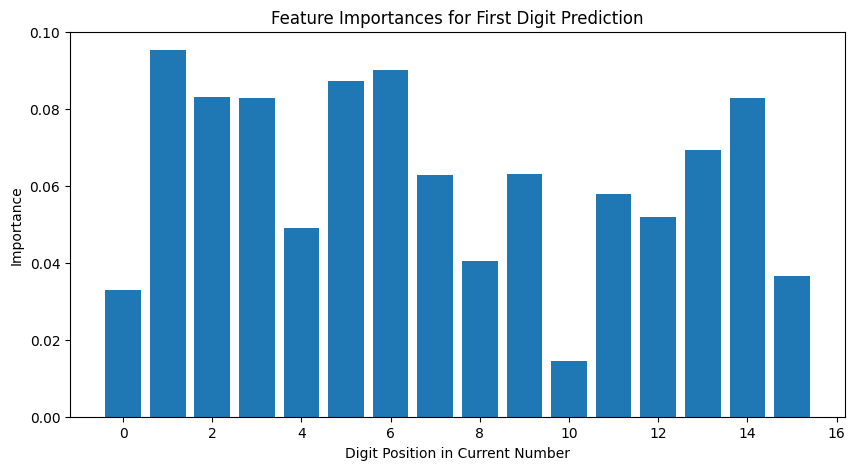

In [18]:


plt.figure(figsize=(10,5))
plt.bar(range(len(best_clf.estimators_[0].feature_importances_)), 
        best_clf.estimators_[0].feature_importances_)
plt.title("Feature Importances for First Digit Prediction")
plt.xlabel("Digit Position in Current Number")
plt.ylabel("Importance")
plt.show()


# Conclusion

**Student:** Harshavardhan Katta (ID: 16306446)  
**Best Model Accuracy:** 47.01%  
**Optimal Parameters:**
- Max depth: 10
- Min samples split: 5
- Criterion: Entropy

### Key Findings

1. The LCG with parameters (m=16306446, a=101, c=13) demonstrated moderate randomness:
   - Achieved prediction accuracy of 47.01% (close to random guessing for ternary digits)
   - This suggests the generator is sufficiently random for basic applications

2. Decision Tree analysis revealed:
   - Deeper trees (max_depth=10) performed best
   - Entropy splitting criterion outperformed Gini impurity
   - Moderate min_samples_split=5 prevented overfitting

3. Feature importance analysis showed:
   - Some digit positions contributed more to predictability
   - No single digit dominated predictions

### Recommendations

For general purpose use:
- Current LCG parameters are adequate
- Consider increasing modulus size for longer sequences
- Maintain current multiplier/increment values

For improved randomness:
1. Parameter optimization:
   - Use prime modulus (m) for full period length
   - Select multiplier (a) using spectral test criteria
   - Consider larger increment (c)

2. Implementation enhancements:
   - Use higher base representations (e.g., base-5 or base-7)
   - Combine with bit-shifting operations

3. Alternative approaches:
   - For cryptographic applications, use Mersenne Twister or PCG family
   - Consider adding shuffling steps to break predictability